<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/ODE2_Mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu

In [57]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190427


In [0]:
nx = 10
dx = 1. / nx

In [0]:
def f(x):
    '''
        d2(psy)/dx2 = f(x, dpsy/dx, psy)
        This is f() function on the right
    '''
    return tf.math.sin(x) + tf.math.sin(4*x) / 4 + tf.math.sin(8*x) / 8 + tf.math.sin(24*x) / 36


def psy_analytic(x):
    '''
        Analytical solution of current problem
    '''
    return np.exp(-x/5.) * np.sin(x)

def psy_trial(xi, net_out):
    return (tf.constant(-1, dtype='float32') - xi) * (tf.constant(1,dtype='float32') - xi) * net_out

# Build Neural Network

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [0]:
model = Sequential()
model.add(Dense(10, input_shape=(nx, 1), activation='relu'))
model.add(Dense(1,  activation='tanh'))
optimizer = tf.keras.optimizers.Adam()

In [0]:
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)

In [0]:
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(model.variables)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        func = f(x) # right part function
        loss = loss_function(d2y_dx2, func)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

In [64]:
for i in range(1000):
    loss = train_on_batch(x_space)
    if i % 200 == 0:
        print(loss)

tf.Tensor(23.091967, shape=(), dtype=float32)
tf.Tensor(0.40821555, shape=(), dtype=float32)
tf.Tensor(0.046064105, shape=(), dtype=float32)
tf.Tensor(0.03516109, shape=(), dtype=float32)
tf.Tensor(0.018587075, shape=(), dtype=float32)


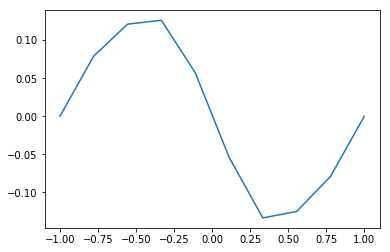

In [65]:
plt.figure()
res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
plt.plot(x_space, res)
plt.show()